(changepoint)=
# Energy signature

## A Bayesian workflow for M&V

This tutorial applies the principles of Bayesian data analysis to a Measurement and Verification (M&V) problem. In a nutshell, M&V aims at reliably assessing the energy savings that were actually gained from energy conservation measures (ECM). One of the main M&V workflows, formalised by the IPMVP, is the "reporting period basis", or "avoided consumption" method:

* a numerical model is trained during a baseline observation period (before ECMs are applied);
* the trained model is used to predict energy consumption during the reporting period (after energy conservation measures);
* predictions are compared with the measured consumption of the reporting period, in order to estimate adjusted energy savings

This method therefore requires data to be recorded before and after implementation of the ECM, for a sufficiently long time. {numref}`mvworkflow` shows the main steps of this method, when following a Bayesian approach. We assume that the measurement boundaries have been defined and that data have been recorded during the baseline and reporting period respectively.

```{figure} /figures/501_workflow.png
---
name: mvworkflow
width: 700px
align: center
---
Estimation of savings with uncertainty in an avoided consumption workflow. The step of model validation is not displayed
```

* As with standard approaches, choose a model structure to describe the data with, and formulate it as a likelihood function. Formulate eventual "expert knowledge" assumptions in the form of prior probability distributions.
* Run a MCMC (or other) algorithm to obtain a set of samples $\left(\theta^{(1)},...,\theta^{(S)}\right)$ which approximates the posterior distribution of parameters conditioned on the baseline data $p(\theta|y_\mathit{base})$. Validate the inference by checking convergence diagnostics: $\hat{R}$, ESS, etc.
* Validate the model by computing its predictions during the baseline period $p(\tilde{y}_\mathit{base}|y_\mathit{base})$. This can be done by taking all (or a representative set of) samples individually, and running a model simulation $\tilde{y}_\mathit{base}^{(s)} \sim p(y_\mathit{base}|\theta=\theta^{(s)})$ for each. This set of simulations generates the posterior predictive distribution of the baseline period, from which any statistic can be derived (mean, median, prediction intervals for any quantile, etc.). The measures of model validation ($R^2$, net determination bias, t-statistic...) can then be computed either from the mean, or from all samples in order to obtain their own probability densities.
* Compute the reporting period predictions in the same discrete way: each sample $\theta^{(s)}$ generates a profile $\tilde{y}_\mathit{repo}^{(s)} \sim p(y_\mathit{repo}|\theta=\theta^{(s)})$, and this set of simulations generates the posterior predictive distribution of the reporting period.
* Since each reporting period prediction $\tilde{y}_\mathit{repo}^{(s)}$ can be compared with the measured reporting period consumption $y_\mathit{repo}$, we can obtain $S$ values for the energy savings, which distribution approximate the posterior probability of savings.

## Energy signature and change-point models

Some systems are dependent on a variable, but only above or below a certain value. For example, cooling energy use may be proportional to ambient temperature, yet only above a certain threshold. When ambient temperature decreases to below the threshold, the cooling energy use does not continue to decrease, because the fan energy remains constant. In cases like these, simple regression can be improved by using a change-point linear regression. Change point models often have a better fit than a simple regression, especially when modeling energy usage for a facility.

A simple energy signature of a building decomposes the total energy consumption $y$ (or power, depending on which measurement is available) into three terms: heating, cooling, and other uses. Heating and cooling are then assumed to be linearly dependent on the outdoor air temperature $x$, and only turned on conditionally on two threshold temperatures $\tau_1$ and $\tau_2$, respectively.

```{math}
:label: cp1
y_n = \alpha + \beta_1(\tau_1-x_n)^+ + \beta_2(x_n-\tau_2)^+ + \varepsilon_n
```

```{math}
:label: cp2
\varepsilon_n \sim \mathrm{normal}\left(0, \sigma\right) 
```

Where the $1$ and $2$ subscripts indicate heating and cooling modes. The $+$ superscript indicates that a term is only applied if above zero. This equation means that we expect the energy use $y$ to be a normal distribution centered around a change-point model, with a constant standard deviation $\sigma$.

Data points should be averaged over long enough (at least daily) sampling times, so that the steady-state assumption formulated above can hold. $\alpha$ is the average baseline consumption during each sampling period, of all energy uses besides heating and cooling. Heating is turned on if the outdoor air temperature drops below a basis temperature $\tau_1$, and the heating power $\beta_1 \, \left(\tau_1 - x_n\right)$ increases linearly with the difference between the change point $\tau_1$ and the outdoor air temperature $x_n$. The same reasoning is used to formulate cooling above a $\tau_2$ change point.

The appeal of the energy signature model is that the only data it requires are energy meter readings and outdoor air temperature, with a large time step size.

This model has 6 possible parameters: a constant term $\alpha$, two slopes $\beta$, two change points $\tau$ and the error scale $\sigma$. It is not an ordinary linear regression models: there is no analytical way to formulate the prediction uncertainty while accounting for the uncertainty of the change point estimates.

## IPMVP option C example with Stan

### Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import arviz as az
from cmdstanpy import CmdStanModel

The data used in this example is the hourly electricity consumption and outdoor air temperature data for a commercial building in Richmond, USA. Three file are available: `building6pre.csv`, `building6during.csv` and `building6post.csv`, respectively before and after some energy conservation measure has been applied.

The following block loads the hourly data, resamples it on daily time steps, and removes week ends.

In [2]:
def load_and_resample_data(file):
    df = pd.read_csv(file)
    df.set_index(pd.to_datetime(df["Date"]), inplace = True)
    df.drop("Date", axis=1, inplace=True)

    df['OAT'] = (df['OAT']-32)/1.8
    df['dayofweek'] = df.index.dayofweek
    df['weekend'] = (df['dayofweek'] == 5) | (df['dayofweek'] == 6)
    df = df.groupby(df.index.date).mean()

    return df

df1 = load_and_resample_data('data/building6pre.csv')
df2 = load_and_resample_data('data/building6during.csv')
df3 = load_and_resample_data('data/building6post.csv')

Averaging the data over daily time steps should allow to overlook the dependence between consecutive measurements. In turn, this allows using a model which will be much simpler than time series models, but will only be capable of low frequency predictions.
 
The next block plot the daily average power consumption (kW) versus the outdoor air temperature (°C) for both datasets: the year used for training (baseline period) and the year used for forecasting (reporting period).

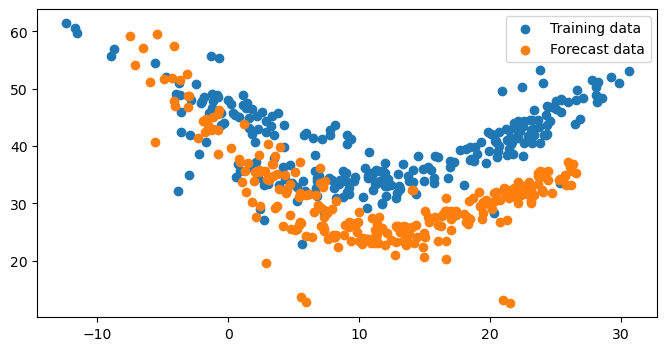

In [3]:
#weekend = (df1['dayofweek'] == 5) | (df1['dayofweek'] == 6)
df_train = df1.loc[df1['weekend']==False]
df_test = df3.loc[df3['weekend']==False]

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(df_train['OAT'], df_train['Building 6 kW'], label='Training data')
ax.scatter(df_test['OAT'], df_test['Building 6 kW'], label='Forecast data')
ax.legend()

### Model specification

After looking at the data, we can suggest using a change-point model which will include the effects of heating and cooling separately, like we defined in Equation {eq}`cp1`above.

The complete Stan code for the energy signature model is written into a separate file, loaded by CmdStanPy:

In [4]:
model = CmdStanModel(stan_file='models/changepoint_101.stan')

I called it "changepoint_101" because it may have a slope on the low temperatures side (1), then a section of temperature-independent energy use (0), then a slope on the high temperatures side (1).

The blocks of the code are separated here to facilitate their description.

First, the data declaration block is more complex than in the previous [linear regression example](linreg_stan) for two reasons:

* Two datasets are being passed to the Stan model: training data, and forecasting data. Each comes with a variable for the number of data entries $N$, input variables $x$ and output $y$.
* Parameter priors are passed as data into the model. This is so that their values can be modified in the main code before refitting, instead of being defined inside the Stan model, which would require recompiling every time we want to try new prior values.

```{code} stan
data {
  // This block declares all data which will be passed to the Stan model.
  // Training period
  int<lower=0> N;       // number of data items
  vector[N] x;      // outdoor temperature
  vector[N] y;      // outcome energy vector
  // Post period
  int<lower=0> N_post;        // number of data items
  vector[N_post] x_post;      // outdoor temperature
  vector[N_post] y_post;      // outcome energy vector
  // Priors
  array[2] real alpha_prior;
  array[2] real beta1_prior;
  array[2] real beta2_prior;
  array[2] real tau1_prior;
  array[2] real tau2_prior;
}
```

The parameter block declares the six parameters of the model as separate real-valued variables:

```{code} stan
parameters {
  // This block declares the parameters of the model.
  real alpha;      // baseline consumption
  real beta1;     // slope for heating
  real beta2;       // slope for cooling
  real tau1;      // low temperature break point
  real tau2;      // high temperature break point
  real<lower=0> sigma;  // error scale
}
```

The model itself is below. First, it declares the prior distribution of each parameter as a normal distribution, with a mean and standard deviation taken from the declared data. Then, the observational model is the energy signature equation {eq}`cp1`.

```{code} stan
model {
  // Assigning prior distributions on some parameters
  alpha ~ normal(alpha_prior[1], alpha_prior[2]);
  beta1 ~ normal(beta1_prior[1], beta1_prior[2]);
  beta2 ~ normal(beta2_prior[1], beta2_prior[2]);
  tau1 ~ normal(tau1_prior[1], tau1_prior[2]);
  tau2 ~ normal(tau2_prior[1], tau2_prior[2]);
  // Observational model
  for (n in 1:N) {
    y[n] ~ normal(alpha + beta1 * fmax(tau1-x[n], 0) + beta2 * fmax(x[n]-tau2, 0), sigma);
  }
}
```

Finally, the block for generated quantities is quite larger than in the previous tutorial. This block handles the calculation of some posterior variables we want to study after fitting:

* Energy use predictions by the model during the training period `y_hat` and during the reporting period `y_hat_post`
* Log-likelihood `log_lik`, which is useful to save if we want to compare several fitted models.
* Energy savings, which are the total difference between the forecasts and the measured reporting period energy use.

```{code} stan
generated quantities {
  // This block is for posterior predictions. It is not part of model training
  array[N] real log_lik;
  array[N] real y_hat;
  array[N_post] real y_hat_post;
  real savings = 0;
  
  for (n in 1:N) {
    y_hat[n] = normal_rng(alpha + beta1 * fmax(tau1-x[n], 0) + beta2 * fmax(x[n]-tau2, 0), sigma);
    log_lik[n] = normal_lpdf(y[n] | alpha + beta1 * fmax(tau1-x[n], 0) + beta2 * fmax(x[n]-tau2, 0), sigma);
  }
  
  for (n in 1:N_post) {
    y_hat_post[n] = normal_rng(alpha + beta1 * fmax(tau1-x_post[n], 0) + beta2 * fmax(x_post[n]-tau2, 0), sigma);
    savings += y_hat_post[n] - y_post[n];
  }
}
```

Note that predictions are calculated by drawing from a Normal distribution with the $\sigma$ error of each sample. Therefore, we will obtain a full description of the prediction intervals.

The next step is to create a list called `model_data`, which maps our data to each appropriate variable into the Stan model. Then the `sample()` command samples from the posterior conditioned on this data.

In [5]:
model_data = {
    "N": len(df_train),
    "x": df_train['OAT'],
    "y": df_train['Building 6 kW'],
    "N_post": len(df_test),
    "x_post": df_test['OAT'],
    "y_post": df_test['Building 6 kW'],
    "alpha_prior": [35, 5], # baseline consumption at intermediate temperatures
    "beta1_prior": [2, 1], # low temperature slope
    "beta2_prior": [2, 1], # high temperature slope
    "tau1_prior": [8, 3], # low temperature break point
    "tau2_prior": [15, 3], # high temperature break point
}

fit = model.sample(data=model_data, show_progress=False)

13:05:23 - cmdstanpy - INFO - CmdStan start processing
13:05:23 - cmdstanpy - INFO - Chain [1] start processing
13:05:23 - cmdstanpy - INFO - Chain [2] start processing
13:05:23 - cmdstanpy - INFO - Chain [4] start processing
13:05:23 - cmdstanpy - INFO - Chain [3] start processing
13:05:39 - cmdstanpy - INFO - Chain [4] done processing
13:05:41 - cmdstanpy - INFO - Chain [2] done processing
13:05:41 - cmdstanpy - INFO - Chain [1] done processing
13:05:42 - cmdstanpy - INFO - Chain [3] done processing


The `diagnose()` method looks for potential problems which indicate that the sample may not be a representative sample from the posterior. If some of the metrics are not satisfactory, Stan's documentation has a page suggesting [how to address these warnings](https://mc-stan.org/misc/warnings.html)..

In [6]:
print(fit.diagnose())

Processing csv files: /tmp/tmp9i6bro8u/changepoint_1016r1rv5rg/changepoint_101-20251020130523_1.csv, /tmp/tmp9i6bro8u/changepoint_1016r1rv5rg/changepoint_101-20251020130523_2.csv, /tmp/tmp9i6bro8u/changepoint_1016r1rv5rg/changepoint_101-20251020130523_3.csv, /tmp/tmp9i6bro8u/changepoint_1016r1rv5rg/changepoint_101-20251020130523_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



If no problems are detected, we can take a look at some metrics from the posterior distributions of model parameters:

In [7]:
fs = fit.summary(percentiles=(5, 50, 95))
fs.loc[['alpha', 'beta1', 'beta2', 'tau1', 'tau2', 'sigma', 'lp__']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,34.53560,0.010216,0.501188,33.678600,34.55910,35.31430,2406.97,72.8656,1.00040
beta1,1.38511,0.001995,0.110079,1.203240,1.38509,1.56559,3043.15,92.1246,1.00239
beta2,1.19328,0.002826,0.131415,0.985353,1.19070,1.41573,2162.66,65.4697,1.00361
tau1,6.57330,0.016033,0.742901,5.493700,6.51567,7.86579,2146.99,64.9953,1.00119
tau2,15.57380,0.024277,1.008360,13.769200,15.64020,17.07890,1725.22,52.2273,1.00269
sigma,4.02903,0.003227,0.184042,3.731860,4.02258,4.34124,3253.27,98.4854,1.00057
lp__,-490.94500,0.045053,1.783120,-494.364000,-490.56600,-488.72300,1566.43,47.4202,1.00265


### Posterior predictions

Our main goal here is to compare the energy use measured during the reporting period $y_\mathit{repo}$ with the predictions of the model trained on the baseline period. Since it is a probabilistic model, its outcome is actually a probability distribution $p\left(\hat{y}_\mathit{repo}|x_\mathit{repo}, x_\mathit{base}, y_\mathit{base}\right)$, based on the observed values of the model inputs $x$ during the baseline and reporting periods, and on the observed energy use during the baseline period $y_\mathit{base}$.

This posterior predictive distribution $p\left(\hat{y}_\mathit{repo}|...\right)$ is already directly available, because a value of $\hat{y}_\mathit{repo}$ (for each time step) was directly calculated by the Stan model for each sample $\theta^{(m)}$ (see [Stan user's guide](https://mc-stan.org/docs/2_26/stan-users-guide/posterior-prediction-chapter.html) for more details).

\begin{equation}
p\left(y_\mathit{repo}|...\right) \approx \frac{1}{M} \sum_{m=1}^M p\left(y_\mathit{repo}|x_\mathit{repo},\theta^{(m)}\right)
\end{equation}

First, let us look at the posterior predictive distribution during the baseline period, in order to validate the model compared to its training data:

In [8]:
# The sampler output is saved into an xarray
res_xr = fit.draws_xr()

# Then the xarray is converted into an ArviZ InferenceData object
idata = az.from_cmdstanpy(
    posterior = fit,
    posterior_predictive="y_hat",
    observed_data={"y": df1['Building 6 kW'].values},
    constant_data={"x": df1[['OAT']].values},
    log_likelihood="log_lik",
    dims={
        "y_hat": ["observations"],
        "log_lik": ["observations"],
        "y": ["observations"],
        "y_hat_post": ["forecast"]
        },
)

Text(0, 0.5, 'Building 6 kW')

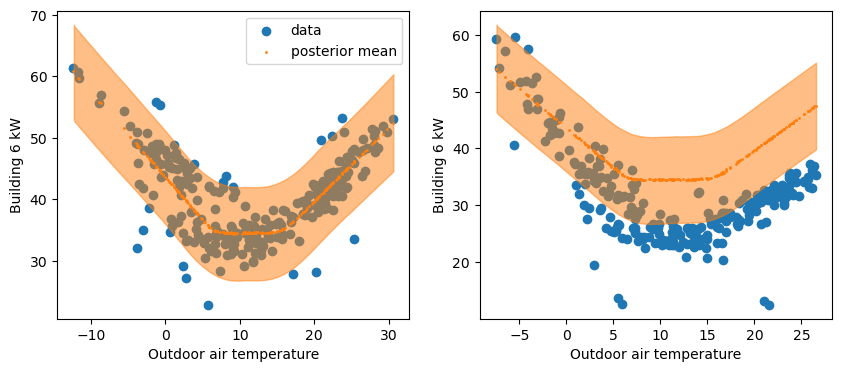

In [9]:
y_hat = idata.posterior_predictive["y_hat"]
y_hat_post = idata.posterior["y_hat_post"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(df_train['OAT'], df_train['Building 6 kW'], label="data")
ax[0].scatter(df_train['OAT'], y_hat.mean(("chain", "draw")), s=1, c="C1", label="posterior mean")
az.plot_hdi(df_train['OAT'], y_hat, ax=ax[0])
ax[0].set_xlabel('Outdoor air temperature')
ax[0].set_ylabel('Building 6 kW')
ax[0].legend()

ax[1].scatter(df_test['OAT'], df_test['Building 6 kW'])
ax[1].scatter(df_test['OAT'], y_hat_post.mean(("chain", "draw")), s=1, c="C1")
az.plot_hdi(df_test['OAT'], y_hat_post, ax=ax[1])
ax[1].set_xlabel('Outdoor air temperature')
ax[1].set_ylabel('Building 6 kW')

Savings

<Axes: title={'center': 'savings'}>

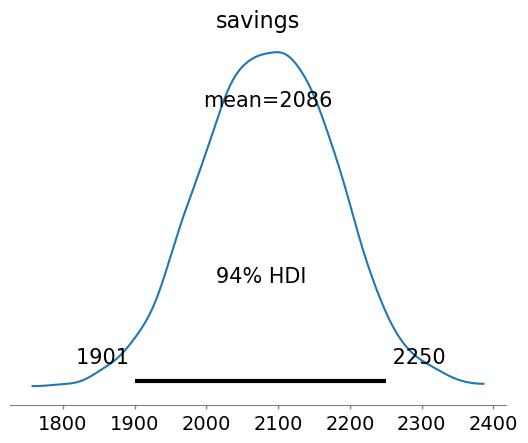

In [10]:
# in kW.day
az.plot_posterior(idata, var_names='savings')

An important validation step is to check for autocorrelation in the residuals of the fitted model, on the baseline data that was used for fitting. Autocorrelation is often a sign of insufficient model complexity, or that the form of the model error term has not been appropriately chosen. In case of strong remaining autocorrelation, inferences should be drawn with caution.

ArviZ has a built-in function to display the autocorrelation of the posterior traces, but we can also use it for a custom variable that is not contained in an InferenceData object.

<Axes: title={'center': 'x\n0'}>

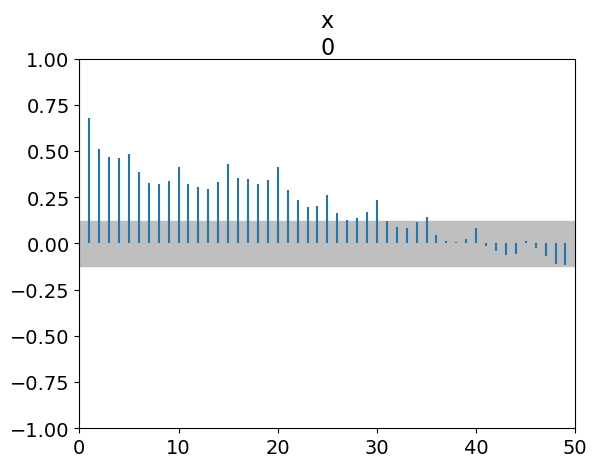

In [14]:
resid = df_train['Building 6 kW'] - y_hat.mean(("chain", "draw"))
az.plot_autocorr(resid.values, max_lag=50)

Every vertical line of this graph shows the correlation coefficient between the values of a series and its own values with a certain lag.

* For `Lag=0`, the ACF is 1. This is normal: a series is fully correlated with itself.
* As much as possible, we want all other ACF values below the dotted line, a threshold value which depends on the length of data.
* For `Lag=1`, the ACF is close to 0.7. This is the average correlation coefficient between residuals and their own previous value. As a consequence, the next lags have high ACF values as well.
* There is an increased ACF every 5 lags. Reminder: we removed weekends, therefore our dataset has 5 rows per week. This suggests that the data has a weekly pattern that our model doesn't capture.

We can zoom in on the lag-1 autocorrelation by plotting residuals versus their own previous value:

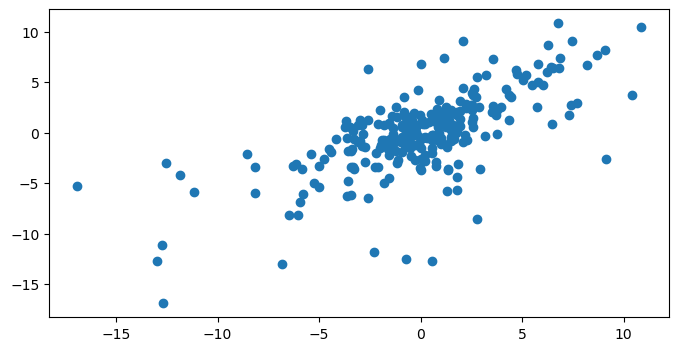

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(resid, resid.shift(1))

The autocorrelation graph suggests that our model doesn't predict the variability of the data properly. We should therefore be very cautious when interpreting its inferences. This includes the uncertainty of the savings estimates.

In order to trust our inferences, we have two options:

* Improve the model so that it better describes the building's electricity use and its dependency on weather and occupancy. This means more model parameters, but the dataset may no longer bring enough information to identify them.
* Modify the model to account for an additional uncertainty due to the autocorrelation. This means we will not "fix" the model, but let it aknowledge that it is missing something: inferences will be more "cautious" (more uncertain but more reliable).

In the next tutorial, we show how to do the second option.